# Imports

In [1]:
%%capture

!pip install category_encoders
!pip install statsmodels

In [1]:
import warnings; 
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

import category_encoders as ce
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier
import scipy as sp
import scipy.fftpack
from fbprophet import Prophet
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler 

# Task 1 (40 points)

* EDA (10 points)
* Explain general setup of feature engineering (10 points)
* Use of scientific literature supporting the setup (5 points)
* Rationale for choice of final attributes (15 points)

In [51]:
df = pd.read_csv('data/mood.csv')
df['time'] = pd.to_datetime(df['time'])
df.head()

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00,mood,6.0
1,2,AS14.01,2014-02-26 15:00:00,mood,6.0
2,3,AS14.01,2014-02-26 18:00:00,mood,6.0
3,4,AS14.01,2014-02-26 21:00:00,mood,7.0
4,5,AS14.01,2014-02-27 09:00:00,mood,6.0


## EDA and preprocessing

In [3]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

We see that the column value contains potential outliers

### What are the dates of the experiment

In [52]:
df.groupby('id')['time'].agg(['min', 'max']).sort_values(['min'])

,min,max
id,,
AS14.02,2014-02-17 07:00:52.197,2014-04-25 21:00:00.000
AS14.06,2014-02-17 07:12:13.631,2014-05-08 09:00:00.000
AS14.14,2014-02-17 07:49:19.635,2014-05-05 15:00:00.000
AS14.17,2014-02-17 08:57:16.313,2014-05-05 15:00:00.000
AS14.19,2014-02-17 08:58:58.471,2014-05-05 18:00:00.000
AS14.28,2014-02-17 09:48:49.536,2014-05-08 13:37:16.006
AS14.20,2014-02-17 09:52:02.075,2014-05-05 13:00:00.000
AS14.26,2014-02-17 09:58:59.766,2014-05-30 21:00:00.000
AS14.29,2014-02-17 10:42:05.661,2014-05-15 12:00:00.000


Most of the participants started at the same time. The experiment lasted for a bit more than 2 months. A couple of participants started 1+ month later. Our guess is that the students are from NL and all live in the same timezone

### What are the values for different kinds of interaction with the device

In [53]:
df.groupby(['variable'])['value'].agg(['min', 'max'])

,min,max
variable,,
activity,0.000,1.000
appCat.builtin,-82798.871,33960.246
appCat.communication,0.006,9830.777
appCat.entertainment,-0.011,32148.677
appCat.finance,0.131,355.513
appCat.game,1.003,5491.793
appCat.office,0.003,32708.818
appCat.other,0.014,3892.038
appCat.social,0.094,30000.906


1. call, sms appear only when there is a fact of this action, so there are no zeros.  
2. the duration of the call may be approximately calculated from the next event (rarely possible).  
3. activity is the value collected hourly. mean sth like the percentage ratio of the hour when the user was active.  
4. mood and circumplex are discrete
5. all the others mean the number of seconds spent on each of the activities

TODO:
1. All activities sum to the screen time
2. Add blink screen usages as a feature

### Outliers

In [54]:
df['variable'].unique()

array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather'],
      dtype=object)

#### appCat.builtin

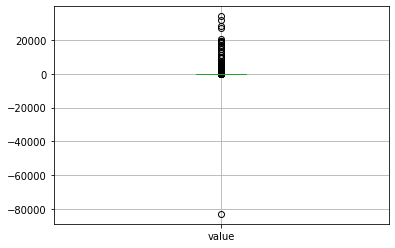

In [55]:
df[df['variable'] == 'appCat.builtin'].boxplot(column=['value']);

In [56]:
df[(df['variable'] == 'appCat.builtin')&(df['value'] < -80000)]

,Unnamed: 0,id,time,variable,value
159972,622771,AS14.07,2014-04-30 14:18:06.200,appCat.builtin,-82798.871


In [57]:
df.shape

(376912, 5)

In [58]:
df.drop(159972, axis=0, inplace=True)
df.shape

(376911, 5)

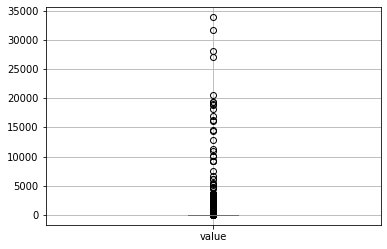

In [59]:
df[df['variable'] == 'appCat.builtin'].boxplot(column=['value']);

In [60]:
# df[df['value'] == df[df['variable'] == 'appCat.builtin'].agg({'value': ['min', 'max']})]

#### appCat.entertainment

In [61]:
df[(df['variable'] == 'appCat.entertainment') & (df['value'] < 0)]

,Unnamed: 0,id,time,variable,value
309805,484694,AS14.02,2014-03-26 21:18:45.144,appCat.entertainment,-0.011


In [62]:
df.drop(309805, axis=0, inplace=True)
df.shape

(376910, 5)

#### appCat.office

In [63]:
df[(df['variable'] == 'appCat.office') & (df['value'] > 5000)]

,Unnamed: 0,id,time,variable,value
340707,1356866,AS14.29,2014-04-19 23:15:02.463,appCat.office,32708.818
342284,1360733,AS14.29,2014-05-03 12:34:14.911,appCat.office,5691.982


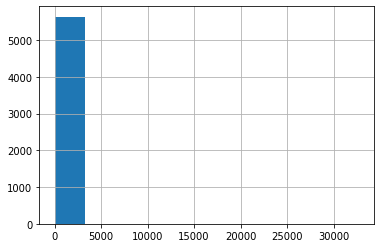

In [64]:
df[df['variable'] == 'appCat.office']['value'].hist();

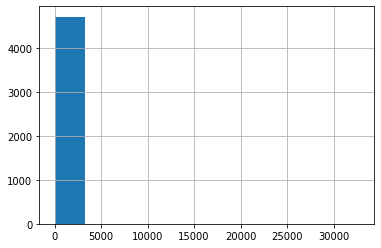

In [65]:
df[(df['id'] == 'AS14.29') & (df['variable'] == 'appCat.office')]['value'].hist();

33k seconds is about 9 hours. In general (and for this subject as well), we see that the time spent in the office apps is significantly smaller so we treat this case as a forgotten opened app

In [66]:
df.drop(340707, axis=0, inplace=True)
df.shape

(376909, 5)

### Activity. Can it be a proxy for sleep? 

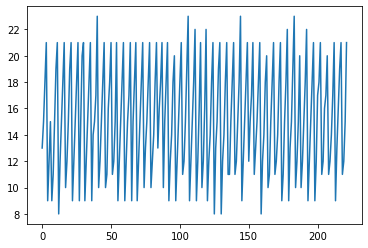

In [67]:
df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')].sort_values(['time'])['time'].dt.hour.plot();

In [68]:
sorted(df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')].sort_values(['time'])['time'].dt.hour.unique())

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

<Figure size 1224x864 with 0 Axes>

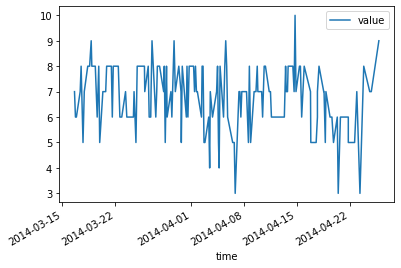

In [69]:
plt.figure(figsize=(17, 12))
df[(df['id'] == 'AS14.02') & (df['variable'] == 'mood')].sort_values(['time']).plot('time', 'value');

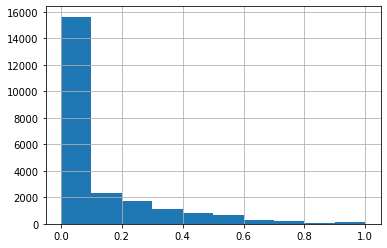

In [70]:
df[df['variable'] == 'activity']['value'].hist();

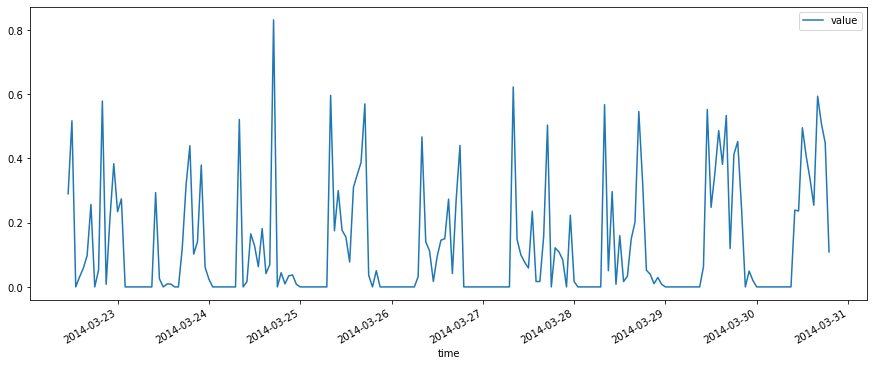

In [71]:
df[(df['id'] == 'AS14.03') & (df['variable'] == 'activity')].sort_values(['time']).head(200).plot(x='time', y='value', figsize=(15,6));

TODO: 
1. add a binary (sth else) feature for sleep\not. sleep should be mutually exclusive with mood records
    1. continous period of 5+ hours
    2. correct it with surrounding events 
2. for each of the users use 75% percentile as sports

### Was the circumplex collected at the same time as the mood?

In [72]:
Image(url= "images/circumplex_model.png", width=400, height=400)

In [73]:
targets_num_df = df[df['variable'].isin(['mood', 'circumplex.valence', 'circumplex.arousal'])].\
    groupby(['id', 'time'])['variable'].unique()
targets_num_df.head()

id       time               
AS14.01  2014-02-26 13:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-26 15:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-26 18:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-26 21:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-27 09:00:00    [mood, circumplex.arousal, circumplex.valence]
Name: variable, dtype: object

In [74]:
targets_num_df[targets_num_df.apply(lambda x: len(x)) != 3]

Series([], Name: variable, dtype: object)

We don't see the cases when mood, circumplex.arousal, circumplex.valence were collected not at the same time. As they are all logically connected, we may conclude that not only the mood was collected as a target during the experiment, but the circumplex as well. Therefore, we have to treat this carefully as including of circumplex while predicting mood for the same time will have a clear leak

### Do we have the same variable indicated at the same time for the same user?

In [75]:
df.duplicated(['id', 'time', 'variable']).value_counts()

False    376866
True         43
dtype: int64

In [76]:
df[df.duplicated(['id', 'time', 'variable'], keep=False)]

,Unnamed: 0,id,time,variable,value
135,136,AS14.01,2014-04-17 11:00:00,mood,7.0
136,137,AS14.01,2014-04-17 11:00:00,mood,6.0
358,359,AS14.02,2014-04-17 18:00:00,mood,6.0
359,360,AS14.02,2014-04-17 18:00:00,mood,7.0
371,372,AS14.02,2014-04-21 20:00:00,mood,5.0
372,373,AS14.02,2014-04-21 20:00:00,mood,6.0
937,938,AS14.06,2014-04-13 17:00:00,mood,7.0
938,939,AS14.06,2014-04-13 17:00:00,mood,5.0
1748,1749,AS14.12,2014-03-30 11:00:00,mood,6.0
1749,1750,AS14.12,2014-03-30 11:00:00,mood,7.0


In [77]:
df[df['variable'] == 'mood']['value'].unique()

array([ 6.,  7.,  5.,  8.,  9.,  4.,  3., 10.,  2.,  1.])

we see the duplicates. probably, they mean fractions (6.5, 0.5 etc)  
TODO Ned: find evidence

In [78]:
df = df.groupby(['id', 'time', 'variable']).mean().reset_index()
df.shape

(376866, 5)

In [79]:
df[(df['id'] == 'AS14.01') & (df['time'] == '2014-04-17 11:00:00')]

,id,time,variable,Unnamed: 0,value
14145,AS14.01,2014-04-17 11:00:00,activity,17559.0,0.05042
14146,AS14.01,2014-04-17 11:00:00,circumplex.arousal,5777.5,-1.50000
14147,AS14.01,2014-04-17 11:00:00,circumplex.valence,11420.5,0.50000
14148,AS14.01,2014-04-17 11:00:00,mood,136.5,6.50000


the unnamed (index) is weird

## Feature engineering non-dependent on train-test split

time may be encoded with a trigonometrical function to link 23 and 0

check the timing(hour) distribution across the days

don't forget to try find their local times (the first measurement is done in the morning)

## Pivoting data from the previous days as features

## Aggregating and Pivoting

In [250]:
# pivot and fill missing timestamps
df['time'] = df['time'].dt.floor('H')
pivoted_df = pd.pivot_table(df, values = 'value', index=['id','time'], columns = 'variable').reset_index()
for idx in pivoted_df['id'].unique():
    df_missing_data = pd.DataFrame()
    start, end = pivoted_df[pivoted_df['id'] == idx]['time'].agg(['min', 'max'])
    df_missing_data['time'] = pd.date_range(start, end, freq="60min").difference(pivoted_df[pivoted_df['id'] == idx]['time'])
    df_missing_data['id'] = idx

pivoted_df = pd.concat([pivoted_df,df_missing_data]).sort_values(['id', 'time'])
pivoted_df.sort_values(['id', 'time'], inplace=True)

In [251]:
# add binary column for sleep (no activity)
pivoted_df.loc[pivoted_df['activity'] == 0,'asleep'] = 1
pivoted_df['asleep'].fillna(0, inplace=True)

In [252]:
# add binary column for high activity
pivoted_df.loc[pivoted_df['activity'] > 0.5,'active'] = 1
pivoted_df['active'].fillna(0, inplace=True)

In [253]:
# add binary column for missing entry (activity value should be present for every hour)
pivoted_df.loc[pivoted_df['activity'].isna(),'missing_hour'] = 1
pivoted_df['missing_hour'].fillna(0, inplace=True)

In [254]:
# aggregate per mood entry
'''
pivoted_df['id_next'] = pivoted_df['id'].shift(-1)
cols = ['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'screen', 'sms']

empty_row = pivoted_df.iloc[0][cols].fillna(0)*0
current_sum = pivoted_df.iloc[0][cols].fillna(0)*0
for i,row in pivoted_df.fillna(0).iterrows():
    if row['id'] == row['id_next']:
        current_sum += row[cols]
    else:
        current_sum = pivoted_df.iloc[0][cols].fillna(0)*0
        
    if row['mood'] != 0.:
        pivoted_df.loc[i,cols] = current_sum[cols]
        current_sum = pivoted_df.iloc[0][cols].fillna(0)*0
        
pivoted_df.drop(pivoted_df[pivoted_df['mood'].isna() == True].index, inplace=True)
pivoted_df.drop('id_next', axis=1,inplace=True)
''';

In [255]:
# calculate the mood change for the previous day
pivoted_df['time'] = pivoted_df['time'].dt.floor('D')
fist = pd.DataFrame(pivoted_df.loc[~pivoted_df['mood'].isna()].groupby(['id', 'time'])['mood'].first())
last = pd.DataFrame(pivoted_df.loc[~pivoted_df['mood'].isna()].groupby(['id', 'time'])['mood'].last())
mood_change = (fist - last)
mood_change.rename(columns={'mood': 'mood_change'}, inplace=True)

In [256]:
#aggregate daily (different agg func for different columns)
pivoted_df['time'] = pivoted_df['time'].dt.floor('D')
df2 = pivoted_df.groupby(['id', 'time']).mean()[['mood', 'circumplex.arousal', 'circumplex.valence']] #calculate mean for mood and circumplex
df3 = pivoted_df.loc[:, ~pivoted_df.columns.isin(['mood', 'circumplex.arousal', 'circumplex.valence'])].groupby(['id', 'time']).sum() #calculate sum for everything else
pivoted_df = pd.concat([df2,df3, mood_change], axis=1).reset_index()

In [257]:
# drop days without mood value
pivoted_df.drop(pivoted_df[pivoted_df['mood'].isna()].index, inplace=True)

In [258]:
# drop days with more than 6 hours missing
pivoted_df.drop(pivoted_df[pivoted_df['missing_hour'] > 6].index, inplace=True)

In [259]:
# add column for mood from previous day and drop rows with no data for previous day
pivoted_df['mood_prev1'] = pivoted_df['mood'].shift(1)
pivoted_df['id_prev1'] = pivoted_df['id'].shift(1)
pivoted_df = pivoted_df[pivoted_df['id_prev1'] == pivoted_df['id']]
pivoted_df.drop('id_prev1', axis=1, inplace=True)

In [260]:
# add column for mood for the next day to be used as target and drop rows with no data for following day
pivoted_df['mood_next'] = pivoted_df['mood'].shift(-1)
pivoted_df['id_next'] = pivoted_df['id'].shift(-1)
pivoted_df = pivoted_df[pivoted_df['id_next'] == pivoted_df['id']]
pivoted_df.drop('id_next', axis=1, inplace=True)

In [261]:
# add day of the week columns
pivoted_df['day_name'] = pivoted_df['time'].dt.day_name()
pivoted_df['day_num'] = pivoted_df['time'].dt.dayofweek

In [262]:
# Estimating weekly seasonality with partial fourier sum
#https://medium.com/analytics-vidhya/how-does-prophet-work-part-2-c47a6ceac511

fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(index=pivoted_df['time'],
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
f=dp.in_sample()
pivoted_df = pd.concat([pivoted_df.set_index('time'),f],axis=1).reset_index()
pivoted_df.drop('trend', axis=1, inplace=True)

In [263]:
# ordinal time encoding
#enc = ce.OrdinalEncoder(cols=['time'])
#pivoted_df = enc.fit_transform(pivoted_df)

In [264]:
# 2 NaN circumplex.valence
# replace with 0 ????
pivoted_df[pivoted_df['circumplex.valence'].isna()]
pivoted_df.fillna(0, inplace=True)

In [265]:
pivoted_df.head(50)

,time,id,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,asleep,active,missing_hour,mood_change,mood_prev1,mood_next,day_name,day_num,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
0,2014-02-27,AS14.01,6.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.0,0.0,3.0,-1.0,6.250000,6.200,Thursday,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
1,2014-03-21,AS14.01,6.200000,0.200000,0.200000,3.083152,230.019006,763.079384,349.711300,12.334933,0.000,117.243500,193.873000,1214.028518,314.312750,0.00000,197.625786,0.000,4.0,3566.876103,0.0,7.0,2.0,0.0,0.0,6.333333,6.400,Friday,4,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2,2014-03-22,AS14.01,6.400000,0.600000,0.500000,3.790084,138.338687,882.779741,46.662000,7.025333,0.000,0.000000,98.143000,205.970250,37.305000,0.00000,117.621000,0.000,2.0,656.267264,1.0,1.0,2.0,0.0,2.0,6.200000,6.800,Saturday,5,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490
3,2014-03-23,AS14.01,6.800000,0.200000,0.800000,2.141117,145.124771,746.957427,49.187000,10.850750,0.000,0.000000,72.823000,369.885567,0.000000,0.00000,30.086000,30.386,0.0,974.988754,0.0,1.0,0.0,0.0,1.0,6.400000,6.000,Sunday,6,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969
4,2014-03-24,AS14.01,6.000000,0.800000,0.000000,1.895065,84.611298,698.855193,144.745286,11.368667,0.000,3.010000,66.558000,622.299232,83.961000,0.00000,178.732000,0.000,4.0,1313.119081,0.0,10.0,0.0,0.0,-1.0,6.800000,6.750,Monday,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
5,2014-03-25,AS14.01,6.750000,0.500000,0.500000,2.360979,172.880177,931.204409,68.206000,10.763500,0.000,0.000000,125.156500,700.452361,0.000000,108.26125,44.578600,0.000,0.0,4218.026801,1.0,7.0,1.0,0.0,0.0,6.000000,6.600,Tuesday,1,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
6,2014-03-26,AS14.01,6.600000,-0.200000,0.600000,2.431400,146.039865,893.799534,588.263667,17.443667,0.000,0.000000,97.498000,1504.717317,0.000000,0.00000,33.365000,0.000,0.0,2389.568615,0.0,8.0,1.0,0.0,0.0,6.750000,7.000,Wednesday,2,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
7,2014-03-27,AS14.01,7.000000,0.200000,0.800000,3.509234,114.537705,1403.517290,268.855500,14.073000,0.000,28.429444,58.532000,693.608000,23.657000,0.00000,50.243500,0.000,1.0,1468.813362,1.0,9.0,3.0,0.0,0.0,6.600000,6.400,Thursday,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
8,2014-03-28,AS14.01,6.400000,-0.600000,0.600000,2.296753,668.463475,351.740333,527.072167,25.276667,116.518,0.000000,225.951000,314.618821,278.752000,0.00000,84.892917,0.000,2.0,826.462362,0.0,10.0,1.0,0.0,-2.0,7.000000,8.000,Friday,4,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
9,2014-03-29,AS14.01,8.000000,0.200000,1.000000,1.636867,302.869607,628.493960,961.423000,0.000000,0.000,0.000000,121.821000,88.853667,17.478333,0.00000,210.479217,0.000,1.0,2468.926018,1.0,8.0,0.0,0.0,1.0,6.400000,7.500,Saturday,5,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490


## Plots + Questions

In [266]:
pd.concat([pivoted_df['mood'] - pivoted_df['mood_prev1'], pivoted_df['mood_change']], axis=1).rename(columns={0: 'mood_change'}).corr()

,mood_change,mood_change
mood_change,1.000000,-0.062877
mood_change,-0.062877,1.000000


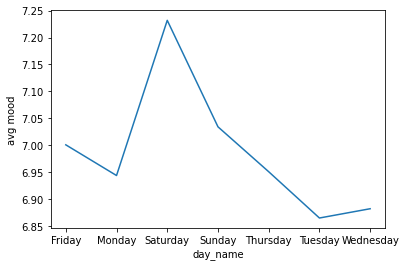

In [267]:
# strong weekly seasonality of mood
pivoted_df.groupby('day_name').mean()['mood'].plot(ylabel='avg mood');

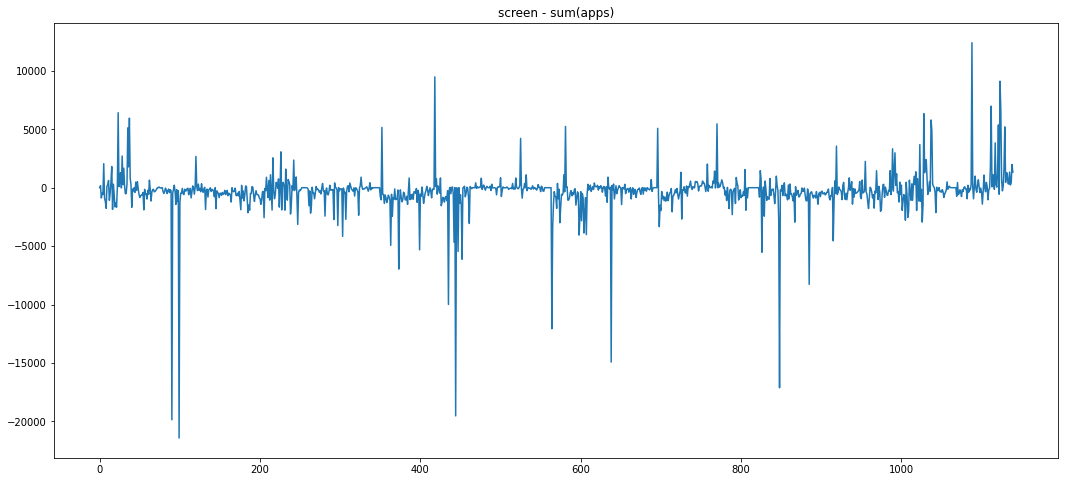

In [268]:
# screen time of apps does not ad up to screen column
%matplotlib inline
apps =  ['appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']
pivoted_df['screen_sum'] = pivoted_df[apps].sum(axis=1)
pivoted_df[['screen','screen_sum']]
(pivoted_df['screen'] - pivoted_df['screen_sum']).plot(figsize=(18,8 ), title='screen - sum(apps)');

### Value for activity missing in more than 14% of the rows!!!
there should be an entry for every hour\
Phone turned off when no data???
currently day deleted if no data for more than 6 hours

## Train-test split

In [102]:
from sklearn.model_selection import train_test_split#, StratifiedKFold

as we are going to predict in the feature, we will be able to train ML models only in the past

In [103]:
pivoted_df = pivoted_df.sort_values(['time'], ascending=True)
pivoted_df.head()

,time,id,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,asleep,active,missing_hour,mood_change_prev,mood_prev1,mood_next,day_name,day_num,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",screen_sum
0,2014-02-27,AS14.01,6.333333,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-1.0,6.250000,6.20,Thursday,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,0.0
555,2014-03-05,AS14.17,8.000000,0.666667,1.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,-2.0,7.000000,7.25,Wednesday,2,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,0.0
252,2014-03-06,AS14.08,7.200000,-0.600000,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,6.0,2.0,6.333333,7.40,Thursday,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,0.0
556,2014-03-06,AS14.17,7.250000,0.500000,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,-1.0,8.000000,7.50,Thursday,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,0.0
253,2014-03-07,AS14.08,7.400000,0.600000,1.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,-1.0,7.200000,7.00,Friday,4,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,0.0


TODO: consider one model per each id (with a separate split for each)

In [104]:
#pivoted_df['mood'].value_counts()

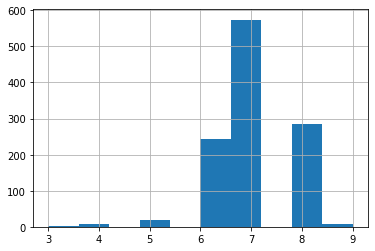

In [105]:
pivoted_df['mood'] = round(pivoted_df['mood'])
pivoted_df['mood'].hist();

In [269]:
y = pivoted_df['mood_next']

X_train, X_test, y_train, y_test = train_test_split(pivoted_df.drop(['mood_next', 'time', 'day_name'], axis=1), 
                                                    y, train_size=0.7, shuffle=False)

## Feature engineering

### Categoricals

ID may be encoded in advance as we do not expect new users during test period

In [270]:
enc = ce.OneHotEncoder(cols=['id'], 
                       use_cat_names=True)

X_train = enc.fit_transform(X_train)
print('X_train.shape', X_train.shape)
X_train.head(3)

X_train.shape (798, 51)


,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,asleep,active,missing_hour,mood_change,mood_prev1,day_num,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",screen_sum
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.333333,0.0,0.333333,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.0000,0.000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,3.0,-1.0,6.250000,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,0.000000
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.200000,0.2,0.200000,3.083152,230.019006,763.079384,349.7113,12.334933,0.0,117.2435,193.873,1214.028518,314.31275,0.0,197.625786,0.0,4.0,3566.876103,0.0,7.0,2.0,0.0,0.0,6.333333,4,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,3392.228177
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.400000,0.6,0.500000,3.790084,138.338687,882.779741,46.6620,7.025333,0.0,0.0000,98.143,205.970250,37.30500,0.0,117.621000,0.0,2.0,656.267264,1.0,1.0,2.0,0.0,2.0,6.200000,5,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,1533.845012


In [271]:
X_test = enc.transform(X_test)
X_test.tail(2)

,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,asleep,active,missing_hour,mood_change,mood_prev1,day_num,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",screen_sum
1138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.2,0.000000,1.2,2.479228,152.595619,340.446362,421.789167,0.0,0.0,76.996733,145.89915,1458.191042,0.000,0.0,5.111,0.0,4.0,4588.272501,1.0,12.0,0.0,0.0,3.0,6.2,2,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,2601.029073
1139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0,-1.333333,1.0,4.064507,91.483901,363.487000,136.738000,0.0,0.0,0.000000,29.20200,548.205000,0.939,0.0,3.199,0.0,4.0,2494.684556,1.0,13.0,1.0,0.0,0.0,8.2,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,1173.253901


### Normalising

# Task 2

## Evaluation

In [209]:
def eval_clf(y_test, test_pred):
    clf_report = classification_report(y_test,
                                       test_pred,)

    print(clf_report)

    conf_matrix = confusion_matrix(y_test,
                                   test_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_test))
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.grid(False)
    disp.plot(ax=ax)

## Predict mood same as previous mood entry baseline (Benchmark Model (4 points))

In [110]:
pivoted_df_per_mood['time'] = df['time'].dt.floor('D')
mood = pivoted_df_per_mood.groupby(['id', 'time']).mean().reset_index()['mood'].round(0)
mood_prev = pivoted_df_per_mood.groupby(['id', 'time']).mean().reset_index()['mood_prev1'].round(0)

NameError: name 'pivoted_df_per_mood' is not defined

In [111]:
eval_clf(mood, mood_prev)

NameError: name 'mood' is not defined

## Predict mood same as previous day baseline (Benchmark Model (4 points))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.29      0.29      0.29         7
         5.0       0.11      0.11      0.11        19
         6.0       0.47      0.46      0.46       247
         7.0       0.60      0.61      0.60       569
         8.0       0.47      0.47      0.47       285
         9.0       0.00      0.00      0.00        11

    accuracy                           0.52      1140
   macro avg       0.28      0.28      0.28      1140
weighted avg       0.52      0.52      0.52      1140



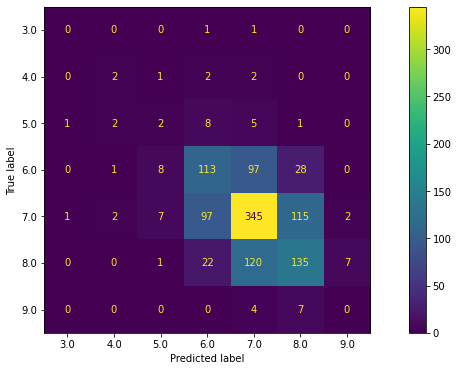

In [112]:
eval_clf(pivoted_df['mood_next'].round(0), pivoted_df['mood'].round(0))

## Average baseline (Benchmark Model (4 points))

In [113]:
avg_mood = np.mean(y_train)

In [114]:
avg_mood

6.990925229741019

In [115]:
test_pred = np.full(y_test.shape, round(avg_mood))

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         9
         6.0       0.00      0.00      0.00        68
         7.0       0.54      1.00      0.70       183
         8.0       0.00      0.00      0.00        79
         9.0       0.00      0.00      0.00         3

    accuracy                           0.54       342
   macro avg       0.11      0.20      0.14       342
weighted avg       0.29      0.54      0.37       342



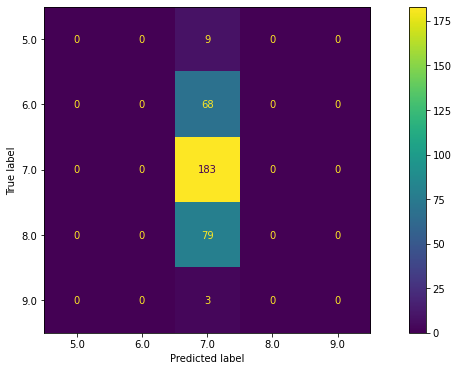

In [119]:
eval_clf(y_test.round(0), test_pred)

## Feature Engineered model (8 points)

### DecisionTreeClassifier

In [120]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train.round(0))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       1.00      0.14      0.25         7
         5.0       1.00      0.30      0.46        10
         6.0       0.67      0.26      0.38       179
         7.0       0.58      0.77      0.66       386
         8.0       0.53      0.54      0.54       206
         9.0       0.00      0.00      0.00         8

    accuracy                           0.58       798
   macro avg       0.54      0.29      0.33       798
weighted avg       0.59      0.58      0.55       798



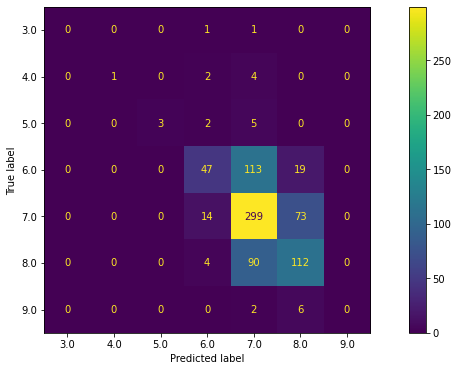

In [121]:
train_pred = clf.predict(X_train)
eval_clf(y_train.round(0), train_pred.round(0))

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         9
         6.0       0.45      0.21      0.28        68
         7.0       0.59      0.80      0.68       183
         8.0       0.45      0.35      0.40        79
         9.0       0.00      0.00      0.00         3

    accuracy                           0.55       342
   macro avg       0.30      0.27      0.27       342
weighted avg       0.51      0.55      0.51       342



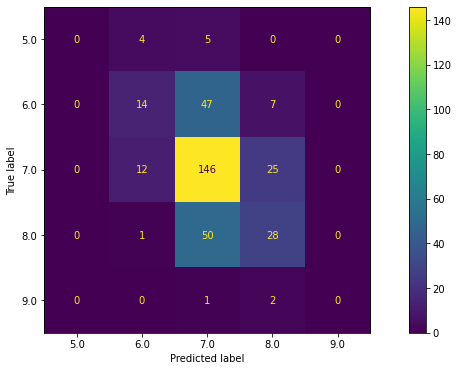

In [122]:
test_pred = clf.predict(X_test)
eval_clf(y_test.round(0), test_pred.round(0))

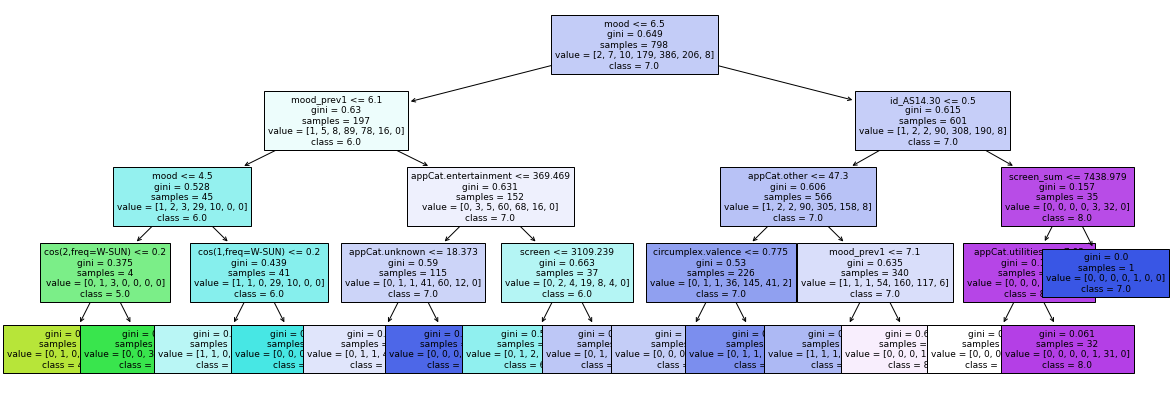

In [123]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1,
                        ncols=1,
                        figsize=(20, 7))

from sklearn import tree
tree.plot_tree(clf, 
               feature_names=X_test.columns, 
               class_names=[str(c) for c in clf.classes_],
            filled=True,
            max_depth=4,
            fontsize=9,
               );

In [499]:
y_test[X_test[X_test['id_AS14.30'] == 1].index]

KeyError: 'id_AS14.30'

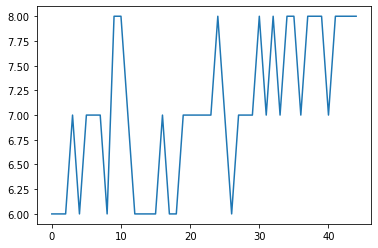

In [124]:
pivoted_df[pivoted_df['id'] == 'AS14.01']['mood'].plot();

### RandomForestClassifier

In [125]:
from sklearn.ensemble import RandomForestClassifier

In [337]:
X_train.columns

Index(['id_AS14.01', 'id_AS14.02', 'id_AS14.03', 'id_AS14.05', 'id_AS14.06',
       'id_AS14.07', 'id_AS14.08', 'id_AS14.09', 'id_AS14.12', 'id_AS14.13',
       'id_AS14.14', 'id_AS14.15', 'id_AS14.16', 'id_AS14.17', 'id_AS14.19',
       'id_AS14.20', 'id_AS14.23', 'id_AS14.24', 'id_AS14.25', 'mood',
       'circumplex.arousal', 'circumplex.valence', 'activity',
       'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
       'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other',
       'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities',
       'appCat.weather', 'call', 'screen', 'sms', 'asleep', 'active',
       'missing_hour', 'mood_change', 'mood_prev1', 'day_num',
       'sin(1,freq=W-SUN)', 'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)',
       'cos(2,freq=W-SUN)', 'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)',
       'screen_sum'],
      dtype='object')

In [343]:
features = ['mood',
       'circumplex.arousal', 'circumplex.valence', 'activity',
       'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
       'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other',
       'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities',
       'appCat.weather', 'call', 'screen', 'sms', 'asleep', 'active',
       'missing_hour', 'mood_change', 'mood_prev1', 'day_num',
       'sin(1,freq=W-SUN)', 'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)',
       'cos(2,freq=W-SUN)', 'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)',
       'screen_sum']

              precision    recall  f1-score   support

         3.0       1.00      1.00      1.00         2
         4.0       1.00      1.00      1.00         7
         5.0       1.00      1.00      1.00        14
         6.0       1.00      0.99      1.00       190
         7.0       1.00      1.00      1.00       427
         8.0       1.00      0.99      1.00       153
         9.0       1.00      1.00      1.00         5

    accuracy                           1.00       798
   macro avg       1.00      1.00      1.00       798
weighted avg       1.00      1.00      1.00       798



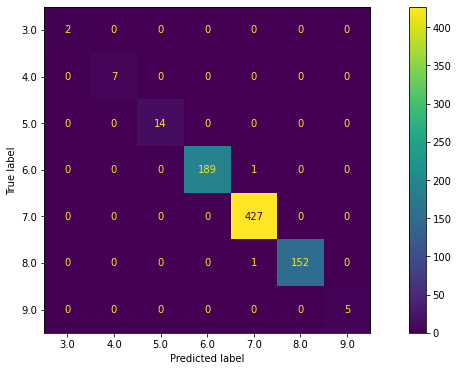

In [377]:
clf = RandomForestClassifier(max_depth=15)
clf = clf.fit(X_train[features], y_train.round(0))

train_pred = clf.predict(X_train[features])
eval_clf(y_train.round(0), train_pred.round(0))

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         5
         6.0       0.38      0.26      0.31        57
         7.0       0.46      0.79      0.58       142
         8.0       0.61      0.28      0.38       132
         9.0       0.00      0.00      0.00         6

    accuracy                           0.48       342
   macro avg       0.29      0.27      0.26       342
weighted avg       0.49      0.48      0.44       342



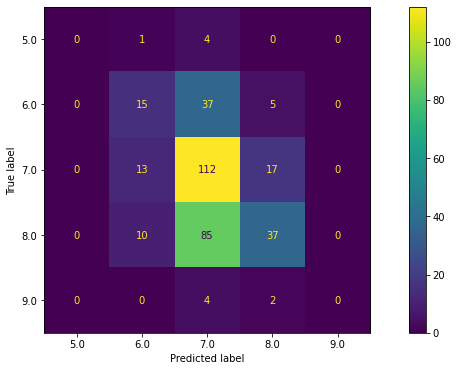

In [378]:
test_pred = clf.predict(X_test[features])
eval_clf(y_test.round(0), test_pred.round(0))

In [379]:
for el in sorted(zip(X_train[features].columns, clf.feature_importances_), key=lambda x: x[1], 
                 reverse=True):
    print(el)

('mood', 0.09096043041219348)
('mood_prev1', 0.06959752710285295)
('appCat.builtin', 0.05147984916961242)
('screen_sum', 0.05039935503718268)
('appCat.other', 0.0497566246657891)
('screen', 0.04911185369276951)
('activity', 0.0482459769559757)
('appCat.communication', 0.04491339050553924)
('circumplex.valence', 0.0433608831783009)
('appCat.social', 0.042222251161113625)
('circumplex.arousal', 0.03969121798234885)
('appCat.entertainment', 0.036321878502222946)
('asleep', 0.036200008267637)
('mood_change', 0.032485902434357186)
('appCat.finance', 0.026648283927089626)
('appCat.utilities', 0.026317073703148505)
('appCat.travel', 0.025133645318712802)
('call', 0.02489427667839996)
('active', 0.01836254026462037)
('day_num', 0.0179598291087276)
('appCat.unknown', 0.01794080645445426)
('sin(2,freq=W-SUN)', 0.017875188979469724)
('cos(1,freq=W-SUN)', 0.017812905513421764)
('sin(3,freq=W-SUN)', 0.017808984722073384)
('sin(1,freq=W-SUN)', 0.017208323615559667)
('appCat.office', 0.01669445687110

## Linear Model

In [279]:
X_train.columns

Index(['id_AS14.01', 'id_AS14.02', 'id_AS14.03', 'id_AS14.05', 'id_AS14.06',
       'id_AS14.07', 'id_AS14.08', 'id_AS14.09', 'id_AS14.12', 'id_AS14.13',
       'id_AS14.14', 'id_AS14.15', 'id_AS14.16', 'id_AS14.17', 'id_AS14.19',
       'id_AS14.20', 'id_AS14.23', 'id_AS14.24', 'id_AS14.25', 'mood',
       'circumplex.arousal', 'circumplex.valence', 'activity',
       'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
       'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other',
       'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities',
       'appCat.weather', 'call', 'screen', 'sms', 'asleep', 'active',
       'missing_hour', 'mood_change', 'mood_prev1', 'day_num',
       'sin(1,freq=W-SUN)', 'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)',
       'cos(2,freq=W-SUN)', 'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)',
       'screen_sum'],
      dtype='object')

In [396]:
features = ['mood',
       'circumplex.arousal', 'circumplex.valence', 'activity',
       'appCat.weather',
       'missing_hour', 'mood_prev1', 'day_num',
       'sin(1,freq=W-SUN)',
       'screen_sum']

In [397]:
X_train[features]

,mood,circumplex.arousal,circumplex.valence,activity,appCat.weather,missing_hour,mood_prev1,day_num,"sin(1,freq=W-SUN)",screen_sum
0,6.333333,0.000000,0.333333,0.000000,0.0000,3.0,6.250000,3,0.433884,0.000000
1,6.200000,0.200000,0.200000,3.083152,0.0000,0.0,6.333333,4,-0.433884,3392.228177
2,6.400000,0.600000,0.500000,3.790084,0.0000,0.0,6.200000,5,-0.974928,1533.845012
3,6.800000,0.200000,0.800000,2.141117,30.3860,0.0,6.400000,6,-0.781831,1455.300514
4,6.000000,0.800000,0.000000,1.895065,0.0000,0.0,6.800000,0,0.000000,1894.140675
5,6.750000,0.500000,0.500000,2.360979,0.0000,0.0,6.000000,1,0.781831,2161.502796
6,6.600000,-0.200000,0.600000,2.431400,0.0000,0.0,6.750000,2,0.974928,3281.127050
7,7.000000,0.200000,0.800000,3.509234,0.0000,0.0,6.600000,3,0.433884,2655.453439
8,6.400000,-0.600000,0.600000,2.296753,0.0000,0.0,7.000000,4,-0.433884,2593.285380
9,8.000000,0.200000,1.000000,1.636867,0.0000,0.0,6.400000,5,-0.974928,2331.418784


In [398]:
model = linear_model.LinearRegression(positive=True)
model.fit(X_train[features], y_train)

LinearRegression(positive=True)

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         7
         5.0       0.43      0.21      0.29        14
         6.0       0.55      0.25      0.35       190
         7.0       0.58      0.92      0.71       427
         8.0       0.67      0.12      0.20       153
         9.0       0.00      0.00      0.00         5

    accuracy                           0.58       798
   macro avg       0.32      0.21      0.22       798
weighted avg       0.58      0.58      0.51       798



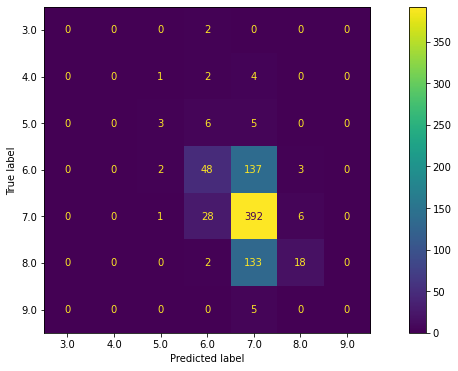

In [399]:
train_pred = pd.DataFrame(model.predict(X_train[features])).round(0)
eval_clf(y_train.round(0), train_pred.round(0))

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         5
         6.0       0.37      0.12      0.18        57
         7.0       0.46      0.87      0.60       142
         8.0       0.70      0.29      0.41       132
         9.0       0.00      0.00      0.00         6

    accuracy                           0.49       342
   macro avg       0.31      0.26      0.24       342
weighted avg       0.52      0.49      0.44       342



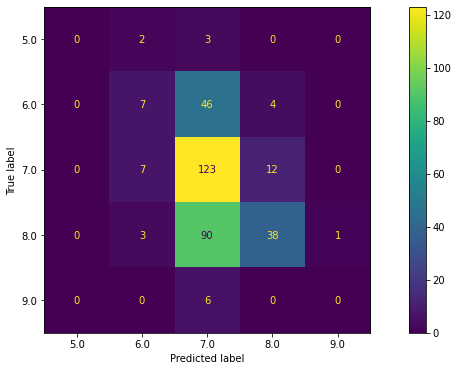

In [400]:
test_pred = pd.DataFrame(model.predict(X_test[features])).round(0)
eval_clf(y_test.round(0), test_pred.round(0))

In [401]:
feature_importance = {}
feature_importance['feature'] = X_test[features].columns
feature_importance['importance'] = model.coef_
feature_importance = pd.DataFrame(feature_importance)
feature_importance.sort_values('importance', ascending=False)

,feature,importance
0,mood,0.369804
6,mood_prev1,0.216265
8,"sin(1,freq=W-SUN)",0.068733
5,missing_hour,0.020832
2,circumplex.valence,0.016426
7,day_num,0.015848
3,activity,0.013719
4,appCat.weather,0.002719
1,circumplex.arousal,0.002140
9,screen_sum,0.000016


## Temporal Model 8

TODO NED: add plots

### AR model

### ARIMA

In [260]:
y = train_test_dict['AS14.01']['train']

# Maps each participant to a fitted model
model_dict = {}
for participant in participants:
    train = train_test_dict[participant]['train']
    
    model = pm.auto_arima(train, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality (Might have to check for this shit?)
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    model_dict[participant] = model

for participant in sorted(model_dict.keys()):
    model = model_dict[participant]
    print(f"{participant}\t\tAIC: {np.round(model.aic(), 2):.2f}\tBIC: {np.round(model.bic(), 2):.2f}\tParameters: {model.order}")

NameError: name 'train_test_dict' is not defined

### Prophet

In [402]:
y_pred = pd.DataFrame()
y_test = pd.DataFrame()
for idx in pivoted_df['id'].unique():
    train = pivoted_df.loc[pivoted_df['id'] == idx,['time', 'mood_next']].iloc[:-10].rename(columns={'time': 'ds', 'mood_next': 'y'})
    test = pivoted_df.loc[pivoted_df['id'] == idx,['time', 'mood_next']].iloc[-10:].rename(columns={'time': 'ds', 'mood_next': 'y'})

    m = Prophet(interval_width=0.95, weekly_seasonality=True);
    model = m.fit(train);

    #future = m.make_future_dataframe(periods=10,freq='D')
    forecast = m.predict(pd.DataFrame(test['ds']));
    y_pred = pd.concat([y_pred, forecast['yhat']])
    y_test = pd.concat([y_test, test['y']])
    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -1.29626
Iteration  1. Log joint probability =     31.268. Improved by 32.5643.
Iteration  2. Log joint probability =    82.0617. Improved by 50.7937.
Iteration  3. Log joint probability =     84.516. Improved by 2.45427.
Iteration  4. Log joint probability =    85.4555. Improved by 0.939533.
Iteration  5. Log joint probability =    85.4617. Improved by 0.00623793.
Iteration  6. Log joint probability =    85.4651. Improved by 0.00332753.
Iteration  7. Log joint probability =    85.4743. Improved by 0.00926221.
Iteration  8. Log joint probability =     85.476. Improved by 0.0016378.
Iteration  9. Log joint probability =    85.5862. Improved by 0.110277.
Iteration 10. Log joint probability =    85.7849. Improved by 0.19862.
Iteration 11. Log joint probability =    85.7854. Improved by 0.000571917.
Iteration 12. Log joint probability =    85.8356. Improved by 0.0501323.
Iteration 13. Log joint probability =    85.8999. Improved by 0.0643746.
Iteration 14. 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = -7.33423
Iteration  1. Log joint probability =     30.723. Improved by 38.0573.
Iteration  2. Log joint probability =    31.0001. Improved by 0.27705.
Iteration  3. Log joint probability =    45.0209. Improved by 14.0208.
Iteration  4. Log joint probability =    48.0943. Improved by 3.07347.
Iteration  5. Log joint probability =    48.9925. Improved by 0.89812.
Iteration  6. Log joint probability =     49.023. Improved by 0.0305178.
Iteration  7. Log joint probability =    49.0387. Improved by 0.0157634.
Iteration  8. Log joint probability =    49.0848. Improved by 0.0460064.
Iteration  9. Log joint probability =    49.1135. Improved by 0.0287739.
Iteration 10. Log joint probability =    49.1552. Improved by 0.0416616.
Iteration 11. Log joint probability =    49.3392. Improved by 0.184015.
Iteration 12. Log joint probability =    49.3665. Improved by 0.0272632.
Iteration 13. Log joint probability =    49.5682. Improved by 0.201705.
Iteration 14. Log joi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -0.332859
Iteration  1. Log joint probability =    64.1345. Improved by 64.4674.
Iteration  2. Log joint probability =    76.9903. Improved by 12.8558.
Iteration  3. Log joint probability =    97.6419. Improved by 20.6515.
Iteration  4. Log joint probability =    99.0084. Improved by 1.36649.
Iteration  5. Log joint probability =    99.1571. Improved by 0.148697.
Iteration  6. Log joint probability =    99.1598. Improved by 0.00273677.
Iteration  7. Log joint probability =     99.208. Improved by 0.0482419.
Iteration  8. Log joint probability =     99.263. Improved by 0.054997.
Iteration  9. Log joint probability =    99.2766. Improved by 0.0135243.
Iteration 10. Log joint probability =    99.3017. Improved by 0.0251508.
Iteration 11. Log joint probability =    99.4209. Improved by 0.119154.
Iteration 12. Log joint probability =    99.4576. Improved by 0.0367749.
Iteration 13. Log joint probability =    99.5728. Improved by 0.115191.
Iteration 14. Log j

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -3.4653
Iteration  1. Log joint probability =    35.5508. Improved by 39.0161.
Iteration  2. Log joint probability =    56.3246. Improved by 20.7738.
Iteration  3. Log joint probability =    67.4759. Improved by 11.1514.
Iteration  4. Log joint probability =    68.5334. Improved by 1.05746.
Iteration  5. Log joint probability =    68.5936. Improved by 0.0602472.
Iteration  6. Log joint probability =    68.7004. Improved by 0.10676.
Iteration  7. Log joint probability =    68.7235. Improved by 0.023132.
Iteration  8. Log joint probability =    68.7423. Improved by 0.0187128.
Iteration  9. Log joint probability =    68.7617. Improved by 0.0194739.
Iteration 10. Log joint probability =    68.7862. Improved by 0.0244653.
Iteration 11. Log joint probability =    68.7884. Improved by 0.00222883.
Iteration 12. Log joint probability =    68.8017. Improved by 0.0132875.
Iteration 13. Log joint probability =    68.8097. Improved by 0.00800801.
Iteration 14. Log j

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = 0.500175
Iteration  1. Log joint probability =     1.9997. Improved by 1.49952.
Iteration  2. Log joint probability =    12.1993. Improved by 10.1996.
Iteration  3. Log joint probability =    12.2164. Improved by 0.0170914.
Iteration  4. Log joint probability =    12.2571. Improved by 0.0406799.
Iteration  5. Log joint probability =     52.241. Improved by 39.9839.
Iteration  6. Log joint probability =    52.3288. Improved by 0.0878319.
Iteration  7. Log joint probability =     52.744. Improved by 0.415213.
Iteration  8. Log joint probability =     53.094. Improved by 0.349941.
Iteration  9. Log joint probability =    53.1476. Improved by 0.0535923.
Iteration 10. Log joint probability =    53.2562. Improved by 0.108611.
Iteration 11. Log joint probability =    53.5638. Improved by 0.307659.
Iteration 12. Log joint probability =    53.7001. Improved by 0.136241.
Iteration 13. Log joint probability =    53.7419. Improved by 0.0418183.
Iteration 14. Log jo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


748. Improved by 3.50819e-07.
Iteration 97. Log joint probability =    77.5748. Improved by 6.26776e-08.
Iteration 98. Log joint probability =    77.5748. Improved by 2.09014e-07.
Iteration 99. Log joint probability =    77.5748. Improved by 3.1754e-07.
Iteration 100. Log joint probability =    77.5748. Improved by 8.99496e-08.
Iteration 101. Log joint probability =    77.5748. Improved by 3.96582e-07.
Iteration 102. Log joint probability =    77.5748. Improved by 6.48336e-07.
Iteration 103. Log joint probability =    77.5748. Improved by 9.47355e-08.
Iteration 104. Log joint probability =    77.5748. Improved by 4.84606e-09.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -3.09143
Iteration  1. Log joint probability =    24.3746. Improved by 27.466.
Iteration  2. Log joint probability =    40.2133. Improved by 15.8387.
Iteration  3. Log joint probability =    45.6512. Improved by 5.43795.
Iteration  4. Log joint probability =    45.8213. Improved by 0.170038.
Iteration  5. Log joint probability =    46.0293. Improved by 0.208023.
Iteration  6. Log joint probability =    46.0452. Improved by 0.0158742.
Iteration  7. Log joint probability =    46.1006. Improved by 0.0554126.
Iteration  8. Log joint probability =    46.1074. Improved by 0.00676917.
Iteration  9. Log joint probability =    46.1106. Improved by 0.00319583.
Iteration 10. Log joint probability =    46.1107. Improved by 0.000153752.
Iteration 11. Log joint probability =     46.116. Improved by 0.00527505.
Iteration 12. Log joint probability =     46.119. Improved by 0.00297971.
Iteration 13. Log joint probability =    46.1201. Improved by 0.00111293.
Iteration 1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = 0.459703
Iteration  1. Log joint probability =    34.2998. Improved by 33.8401.
Iteration  2. Log joint probability =    49.0272. Improved by 14.7274.
Iteration  3. Log joint probability =    66.1478. Improved by 17.1206.
Iteration  4. Log joint probability =    73.4817. Improved by 7.33395.
Iteration  5. Log joint probability =    74.7895. Improved by 1.30776.
Iteration  6. Log joint probability =    74.7936. Improved by 0.00417693.
Iteration  7. Log joint probability =    74.8182. Improved by 0.0245743.
Iteration  8. Log joint probability =    74.9904. Improved by 0.172162.
Iteration  9. Log joint probability =    75.0057. Improved by 0.0153422.
Iteration 10. Log joint probability =    75.3431. Improved by 0.337354.
Iteration 11. Log joint probability =    75.3975. Improved by 0.0544082.
Iteration 12. Log joint probability =    75.4051. Improved by 0.00759521.
Iteration 13. Log joint probability =    75.4366. Improved by 0.0314908.
Iteration 14. Log j

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.



Initial log joint probability = -2.70549
Iteration  1. Log joint probability =    35.4212. Improved by 38.1266.
Iteration  2. Log joint probability =    59.3152. Improved by 23.894.
Iteration  3. Log joint probability =      67.13. Improved by 7.81489.
Iteration  4. Log joint probability =    67.1584. Improved by 0.0283866.
Iteration  5. Log joint probability =    67.1855. Improved by 0.0271142.
Iteration  6. Log joint probability =    67.1983. Improved by 0.0127188.
Iteration  7. Log joint probability =    67.2779. Improved by 0.0796148.
Iteration  8. Log joint probability =    67.4109. Improved by 0.132999.
Iteration  9. Log joint probability =     67.474. Improved by 0.0631615.
Iteration 10. Log joint probability =    67.5969. Improved by 0.12286.
Iteration 11. Log joint probability =    67.6071. Improved by 0.010227.
Iteration 12. Log joint probability =    67.6251. Improved by 0.017935.
Iteration 13. Log joint probability =    67.6931. Improved by 0.0680675.
Iteration 14. Log joi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.



Initial log joint probability = -5.6661
Iteration  1. Log joint probability =    23.8757. Improved by 29.5418.
Iteration  2. Log joint probability =    40.1617. Improved by 16.286.
Iteration  3. Log joint probability =    50.5413. Improved by 10.3796.
Iteration  4. Log joint probability =     55.852. Improved by 5.31069.
Iteration  5. Log joint probability =    57.0318. Improved by 1.17979.
Iteration  6. Log joint probability =    57.4701. Improved by 0.438343.
Iteration  7. Log joint probability =    57.7797. Improved by 0.30962.
Iteration  8. Log joint probability =    57.8615. Improved by 0.081771.
Iteration  9. Log joint probability =    57.8806. Improved by 0.0190908.
Iteration 10. Log joint probability =    57.8916. Improved by 0.0109932.
Iteration 11. Log joint probability =    57.9063. Improved by 0.0146623.
Iteration 12. Log joint probability =    57.9133. Improved by 0.00703863.
Iteration 13. Log joint probability =    57.9164. Improved by 0.00310576.
Iteration 14. Log joint

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.



Initial log joint probability = -0.918755
Iteration  1. Log joint probability =    32.2308. Improved by 33.1496.
Iteration  2. Log joint probability =    52.3439. Improved by 20.113.
Iteration  3. Log joint probability =    67.6443. Improved by 15.3005.
Iteration  4. Log joint probability =    68.8633. Improved by 1.21895.
Iteration  5. Log joint probability =    69.3052. Improved by 0.441927.
Iteration  6. Log joint probability =    69.3861. Improved by 0.0808824.
Iteration  7. Log joint probability =    69.4172. Improved by 0.0311557.
Iteration  8. Log joint probability =    69.6289. Improved by 0.211667.
Iteration  9. Log joint probability =    69.7632. Improved by 0.134285.
Iteration 10. Log joint probability =    69.7657. Improved by 0.00253383.
Iteration 11. Log joint probability =    69.8307. Improved by 0.0649448.
Iteration 12. Log joint probability =    69.8663. Improved by 0.0356432.
Iteration 13. Log joint probability =    69.8791. Improved by 0.0127962.
Iteration 14. Log j

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.



Initial log joint probability = -0.806369
Iteration  1. Log joint probability =    55.9045. Improved by 56.7109.
Iteration  2. Log joint probability =     63.647. Improved by 7.74244.
Iteration  3. Log joint probability =    75.3704. Improved by 11.7234.
Iteration  4. Log joint probability =    77.4693. Improved by 2.0989.
Iteration  5. Log joint probability =    77.7687. Improved by 0.299438.
Iteration  6. Log joint probability =    78.0142. Improved by 0.245447.
Iteration  7. Log joint probability =    78.0335. Improved by 0.0193178.
Iteration  8. Log joint probability =     78.052. Improved by 0.0185202.
Iteration  9. Log joint probability =    78.1588. Improved by 0.106826.
Iteration 10. Log joint probability =    78.2023. Improved by 0.0435146.
Iteration 11. Log joint probability =    87.1766. Improved by 8.97426.
Iteration 12. Log joint probability =    87.2237. Improved by 0.0470809.
Iteration 13. Log joint probability =     87.252. Improved by 0.0282764.
Iteration 14. Log join

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -1.31061
Iteration  1. Log joint probability =    23.6704. Improved by 24.981.
Iteration  2. Log joint probability =    72.9878. Improved by 49.3174.
Iteration  3. Log joint probability =    73.0106. Improved by 0.0227919.
Iteration  4. Log joint probability =    73.0533. Improved by 0.042733.
Iteration  5. Log joint probability =    73.0874. Improved by 0.0341121.
Iteration  6. Log joint probability =    73.1366. Improved by 0.0491909.
Iteration  7. Log joint probability =    73.1835. Improved by 0.0468603.
Iteration  8. Log joint probability =    73.3787. Improved by 0.195239.
Iteration  9. Log joint probability =    73.5547. Improved by 0.175958.
Iteration 10. Log joint probability =    78.3147. Improved by 4.76009.
Iteration 11. Log joint probability =    80.1819. Improved by 1.8672.
Iteration 12. Log joint probability =     81.644. Improved by 1.46205.
Iteration 13. Log joint probability =    82.6803. Improved by 1.03631.
Iteration 14. Log joint pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -0.396225
Iteration  1. Log joint probability =    36.9848. Improved by 37.381.
Iteration  2. Log joint probability =    60.4599. Improved by 23.4751.
Iteration  3. Log joint probability =    80.3346. Improved by 19.8748.
Iteration  4. Log joint probability =    82.8735. Improved by 2.53885.
Iteration  5. Log joint probability =    85.3048. Improved by 2.43132.
Iteration  6. Log joint probability =    85.3345. Improved by 0.0296476.
Iteration  7. Log joint probability =    85.3481. Improved by 0.0136757.
Iteration  8. Log joint probability =    85.3661. Improved by 0.0179785.
Iteration  9. Log joint probability =    85.3751. Improved by 0.00893372.
Iteration 10. Log joint probability =    85.4058. Improved by 0.0307198.
Iteration 11. Log joint probability =    85.4125. Improved by 0.00671243.
Iteration 12. Log joint probability =    85.4158. Improved by 0.00334783.
Iteration 13. Log joint probability =    85.7065. Improved by 0.290674.
Iteration 14. Log

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -0.392609
Iteration  1. Log joint probability =    37.1817. Improved by 37.5743.
Iteration  2. Log joint probability =     63.593. Improved by 26.4113.
Iteration  3. Log joint probability =    80.6902. Improved by 17.0972.
Iteration  4. Log joint probability =     88.664. Improved by 7.97381.
Iteration  5. Log joint probability =    88.8168. Improved by 0.152815.
Iteration  6. Log joint probability =    88.8347. Improved by 0.0178733.
Iteration  7. Log joint probability =    88.8741. Improved by 0.0394198.
Iteration  8. Log joint probability =    88.8948. Improved by 0.0206825.
Iteration  9. Log joint probability =     88.897. Improved by 0.00222509.
Iteration 10. Log joint probability =    88.9008. Improved by 0.00380516.
Iteration 11. Log joint probability =    88.9118. Improved by 0.0109808.
Iteration 12. Log joint probability =    88.9162. Improved by 0.00441445.
Iteration 13. Log joint probability =    88.9172. Improved by 0.00103611.
Iteration 14.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -10.0704
Iteration  1. Log joint probability =    27.1655. Improved by 37.2359.
Iteration  2. Log joint probability =    41.8701. Improved by 14.7046.
Iteration  3. Log joint probability =     48.885. Improved by 7.01492.
Iteration  4. Log joint probability =    53.2645. Improved by 4.37952.
Iteration  5. Log joint probability =    54.7239. Improved by 1.45934.
Iteration  6. Log joint probability =     54.869. Improved by 0.145154.
Iteration  7. Log joint probability =     54.982. Improved by 0.113013.
Iteration  8. Log joint probability =    55.0081. Improved by 0.0260739.
Iteration  9. Log joint probability =    55.0391. Improved by 0.0310243.
Iteration 10. Log joint probability =    55.0639. Improved by 0.0247334.
Iteration 11. Log joint probability =    55.1391. Improved by 0.0752572.
Iteration 12. Log joint probability =    55.2304. Improved by 0.0912876.
Iteration 13. Log joint probability =    55.2604. Improved by 0.0299627.
Iteration 14. Log joi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = -13.2852
Iteration  1. Log joint probability =    21.6623. Improved by 34.9475.
Iteration  2. Log joint probability =    29.3266. Improved by 7.66437.
Iteration  3. Log joint probability =    34.3194. Improved by 4.99277.
Iteration  4. Log joint probability =    36.5122. Improved by 2.19278.
Iteration  5. Log joint probability =    40.9814. Improved by 4.46919.
Iteration  6. Log joint probability =    41.1903. Improved by 0.208895.
Iteration  7. Log joint probability =    41.2268. Improved by 0.0364783.
Iteration  8. Log joint probability =    41.3146. Improved by 0.0878727.
Iteration  9. Log joint probability =    41.3215. Improved by 0.0068761.
Iteration 10. Log joint probability =    41.3282. Improved by 0.00673225.
Iteration 11. Log joint probability =    41.3676. Improved by 0.0393781.
Iteration 12. Log joint probability =    41.3838. Improved by 0.0161655.
Iteration 13. Log joint probability =     41.393. Improved by 0.00924529.
Iteration 14. Log 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -15.1801
Iteration  1. Log joint probability =    64.0039. Improved by 79.1841.
Iteration  2. Log joint probability =    88.1552. Improved by 24.1513.
Iteration  3. Log joint probability =     116.27. Improved by 28.1148.
Iteration  4. Log joint probability =    116.301. Improved by 0.0312471.
Iteration  5. Log joint probability =    116.305. Improved by 0.00404346.
Iteration  6. Log joint probability =    116.442. Improved by 0.136516.
Iteration  7. Log joint probability =    116.442. Improved by 0.000533628.
Iteration  8. Log joint probability =    116.518. Improved by 0.0751846.
Iteration  9. Log joint probability =    116.545. Improved by 0.0275646.
Iteration 10. Log joint probability =    116.559. Improved by 0.0138878.
Iteration 11. Log joint probability =    116.859. Improved by 0.300071.
Iteration 12. Log joint probability =    117.334. Improved by 0.475319.
Iteration 13. Log joint probability =    118.611. Improved by 1.27653.
Iteration 14. Log

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -6.85821
Iteration  1. Log joint probability =    29.6531. Improved by 36.5113.
Iteration  2. Log joint probability =    52.3106. Improved by 22.6575.
Iteration  3. Log joint probability =    60.4889. Improved by 8.17832.
Iteration  4. Log joint probability =    61.0312. Improved by 0.542263.
Iteration  5. Log joint probability =    61.1576. Improved by 0.126418.
Iteration  6. Log joint probability =    61.2367. Improved by 0.0790554.
Iteration  7. Log joint probability =    61.2408. Improved by 0.00417359.
Iteration  8. Log joint probability =    61.2427. Improved by 0.00187484.
Iteration  9. Log joint probability =    61.2494. Improved by 0.00666142.
Iteration 10. Log joint probability =    61.2635. Improved by 0.0140783.
Iteration 11. Log joint probability =     61.265. Improved by 0.00156057.
Iteration 12. Log joint probability =    61.2693. Improved by 0.00428791.
Iteration 13. Log joint probability =    61.2715. Improved by 0.00223009.
Iteration 1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -1.33786
Iteration  1. Log joint probability =    23.1379. Improved by 24.4757.
Iteration  2. Log joint probability =    61.8048. Improved by 38.6669.
Iteration  3. Log joint probability =     69.331. Improved by 7.52617.
Iteration  4. Log joint probability =    69.3514. Improved by 0.0203989.
Iteration  5. Log joint probability =    69.3781. Improved by 0.0267136.
Iteration  6. Log joint probability =    69.3866. Improved by 0.00853657.
Iteration  7. Log joint probability =    69.4347. Improved by 0.0480884.
Iteration  8. Log joint probability =    69.5737. Improved by 0.139022.
Iteration  9. Log joint probability =    69.6736. Improved by 0.0998965.
Iteration 10. Log joint probability =    69.6803. Improved by 0.00673245.
Iteration 11. Log joint probability =     69.687. Improved by 0.00662229.
Iteration 12. Log joint probability =    69.6886. Improved by 0.00160077.
Iteration 13. Log joint probability =    69.7001. Improved by 0.0115652.
Iteration 14

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = 0.575586
Iteration  1. Log joint probability =    49.1982. Improved by 48.6226.
Iteration  2. Log joint probability =     79.981. Improved by 30.7828.
Iteration  3. Log joint probability =    94.4093. Improved by 14.4283.
Iteration  4. Log joint probability =    95.7755. Improved by 1.36613.
Iteration  5. Log joint probability =    95.9479. Improved by 0.17244.
Iteration  6. Log joint probability =     96.178. Improved by 0.230081.
Iteration  7. Log joint probability =    96.3762. Improved by 0.198201.
Iteration  8. Log joint probability =    96.4236. Improved by 0.04744.
Iteration  9. Log joint probability =    96.4363. Improved by 0.0126399.
Iteration 10. Log joint probability =    96.4379. Improved by 0.0016209.
Iteration 11. Log joint probability =    96.4828. Improved by 0.0449224.
Iteration 12. Log joint probability =    96.5311. Improved by 0.0482957.
Iteration 13. Log joint probability =    96.5892. Improved by 0.0581106.
Iteration 14. Log joint

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = -7.28621
Iteration  1. Log joint probability =      35.81. Improved by 43.0962.
Iteration  2. Log joint probability =     48.839. Improved by 13.0291.
Iteration  3. Log joint probability =    56.5937. Improved by 7.75472.
Iteration  4. Log joint probability =    57.0617. Improved by 0.467985.
Iteration  5. Log joint probability =    57.2056. Improved by 0.143893.
Iteration  6. Log joint probability =    57.2363. Improved by 0.0307009.
Iteration  7. Log joint probability =    57.2659. Improved by 0.0295677.
Iteration  8. Log joint probability =    57.2958. Improved by 0.0298934.
Iteration  9. Log joint probability =    57.3974. Improved by 0.10162.
Iteration 10. Log joint probability =    57.4862. Improved by 0.0887602.
Iteration 11. Log joint probability =    57.5209. Improved by 0.0347935.
Iteration 12. Log joint probability =    57.5692. Improved by 0.0482371.
Iteration 13. Log joint probability =    57.5971. Improved by 0.0279648.
Iteration 14. Log j

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.



Initial log joint probability = -5.56432
Iteration  1. Log joint probability =    13.9816. Improved by 19.5459.
Iteration  2. Log joint probability =    19.8934. Improved by 5.91178.
Iteration  3. Log joint probability =    50.9886. Improved by 31.0953.
Iteration  4. Log joint probability =    51.1803. Improved by 0.191709.
Iteration  5. Log joint probability =    51.4517. Improved by 0.271356.
Iteration  6. Log joint probability =    51.8023. Improved by 0.350614.
Iteration  7. Log joint probability =    51.8532. Improved by 0.0509183.
Iteration  8. Log joint probability =    51.8677. Improved by 0.0145118.
Iteration  9. Log joint probability =     52.368. Improved by 0.500295.
Iteration 10. Log joint probability =    52.3882. Improved by 0.0201231.
Iteration 11. Log joint probability =    52.4569. Improved by 0.0687394.
Iteration 12. Log joint probability =    52.4922. Improved by 0.035352.
Iteration 13. Log joint probability =    52.5929. Improved by 0.100688.
Iteration 14. Log joi

              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         0
         5.0       0.20      0.29      0.24         7
         6.0       0.33      0.30      0.32        53
         7.0       0.60      0.72      0.66       136
         8.0       0.52      0.34      0.41        70
         9.0       0.00      0.00      0.00         4

    accuracy                           0.52       270
   macro avg       0.28      0.28      0.27       270
weighted avg       0.51      0.52      0.51       270



ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (5).

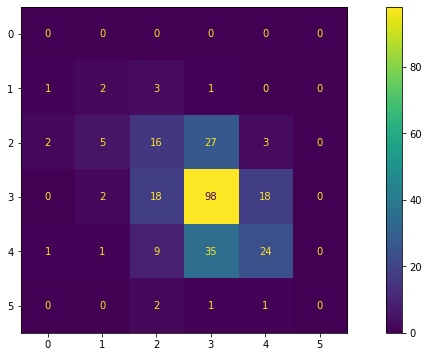

In [403]:
eval_clf(y_test.round(0), y_pred.round(0))

## Evaluation (validation / test) 10

## Illustrate performance with graphs 10